# loading packages

In [2]:
!pip install plotly

     |████████████████████████████████| 7.3MB 425kB/s 
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import numpy as np
import pandas as pd
%matplotlib inline
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import plotly
from time import time

beta_1 = 2
beta_2 = 1

# initial settings

In [4]:
L = 512
r = 0.5

k = 1
N = 1
taken = np.zeros([L,L])     # 数量
possess = np.zeros([L,L]) # 类
all_edges = [(int(L/2),int(L/2))]
edges = [{(int(L/2),int(L/2)):[np.array([L/2.,L/2.])]}]
taken[(int(L/2),int(L/2))] = 1
possess[(int(L/2),int(L/2))] = 1


# Useful functions

In [5]:
# togo
def togo(r = 0.5):
    theta = 2 * np.pi * np.random.random()
    togo =  r * np.array([np.cos(theta),np.sin(theta)])
    return togo

# 是否是边界
def if_edge(block):
    global taken, possess
    neighbors = get_neighbors(block)
    if len(set([possess[neighbor] for neighbor in neighbors])) == 1:
        return False
    else:
        return True
        
# 得到邻居结点
def get_neighbors(block,L = L):
    neighbors = []
    a,b = block
    for i in range(-1,2):
        for j in range(-1,2):
            x,y = a+i,b+j
            if (x<L)&(x>=0)&(y<L)&(y>=0):
                neighbors.append((a + i , b +j))
    neighbors.remove(block)
    return neighbors

In [6]:
def mech_2():
    global k, N, all_edges, edges, taken,possess # ,block,choice,father_block,city,father_node,position
    
    probs = taken.flatten()
    choice = np.random.choice(np.arange(L * L),p = probs/sum(probs))
    father_block = int(choice//L), int(choice%L)
    # 是否是边缘结点
    city = int(possess[father_block])
    if father_block in all_edges:
        father_node =  edges[city-1][father_block][np.random.choice(int(taken[father_block]))]
        position = np.array([2*L,2*L])
        while (position[0] > L) or (position[0] < 0) or (position[1] > L) or (position[1] < 0):
            position = father_node + togo()
        block = tuple(position.astype(int))
        if possess[block] == 0:# 空格子，那么它一定是边界asas
#             print(block) # 边缘
            all_edges.append(block)
            edges[city-1][block] = [position]
            taken[block] = 1
            N += 1
            possess[block] = city
            # 验证邻居是不是边界结点
            neighbors = get_neighbors(block)
            for neighbor in neighbors:
                if (not if_edge(neighbor)) & (neighbors in all_edges):
                    del edges[city-1][neighbor]
                    all_edges.remove(neighbor)
        elif possess[block] == city:
            edges[city-1][block].append(position)
            taken[block] += 1
    else:#不是边缘结点
        father_node = np.array(father_block) + np.random.random(2)
        position = father_node + togo()
        block = position.astype(int)      
        if block in all_edges:
            edges[city-1][block].append(position)
        taken[block] += 1
        N += 1

In [7]:
def mech_1():
    global k, N, all_edges, edges, taken,possess,block
    choice = np.random.randint(L*L)
    block = int(choice//L), int(choice%L)
    position = np.array(block) + togo()
    if possess[block] == 0:
        k += 1
        possess[block] = k
        all_edges.append(block)
        edges.append( {block: [position]} )
        taken[block] = 1
        N+=1
        

# 运行机制

In [8]:
case1 = 0
case2 = 0
def generate(x):
    global k,beta_1,beta_2,N,case1,case2
    if x < ((k*beta_2)/(beta_2*k+beta_1*N)):
        mech_1()
        case1 +=1
    else:
        mech_2()
        case2 +=1

# 运行

In [9]:
p = np.random.random(int(1e8))

In [8]:
for _ in tqdm_notebook(range(int(1e7))):
    generate(p[_]) # 重复一亿次

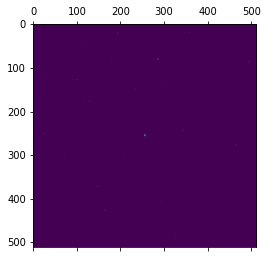

In [9]:
plt.matshow(taken)
plt.savefig('pics/{}_{}_{}.pdf'.format(beta_1,beta_2,time()))

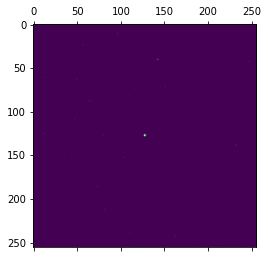

In [10]:
taken64 = taken[:,::2]+taken[:,1::2]
taken64 = taken64[::2,:]+taken64[1::2,:]
plt.matshow(taken64)

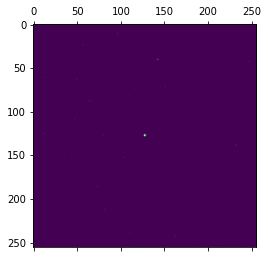

In [11]:
taken64 = taken[:,::2]+taken[:,1::2]
taken64 = taken64[::2,:]+taken64[1::2,:]
plt.matshow(taken64)

In [12]:
k,N, case1, case2

(158192, 262140, 2302070, 7697930)

In [13]:
ranks = []
for i in range(1,k+1):
    ranks.append(sum(taken[possess == i]))

In [14]:
ranks[:5]

[1083076.0, 135195.0, 71967.0, 7818.0, 53903.0]

In [15]:
import powerlaw
results = powerlaw.Fit(ranks)
R, p = results.distribution_compare('power_law', 'lognormal')
results.power_law.alpha, results.power_law.xmin, R, p

Calculating best minimal value for power law fit
C:\Users\xiugz\AppData\Roaming\Python\Python36\site-packages\powerlaw.py:700: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\xiugz\AppData\Roaming\Python\Python36\site-packages\powerlaw.py:1605: RuntimeWarning:

invalid value encountered in true_divide

'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


(2.1647865749288187, 1121.0, 0.007664632712920394, 0.7939756104921826)

# Box counting

In [16]:
def box_counting(edge,r = 2):
    rearrange = []
    for box in range(len(edge)):
        x,y = edge[box]
        new_box = x // r, y // r
        rearrange.append(new_box)
    return list(set(rearrange))

In [17]:
largest_city_edge = list(edges[0].keys())
print(len(largest_city_edge))
rescale_1 = box_counting(largest_city_edge)
len(rescale_1)
rescale_2 = box_counting(rescale_1)
len(rescale_2)

67


9

# area scaling

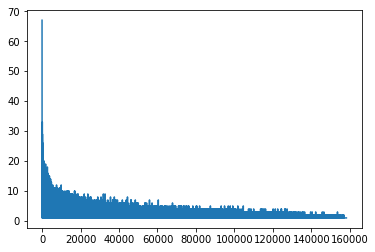

In [18]:
area = []
for i in range(k):
    area.append(sum(sum(possess == i+1)))
plt.plot(area)

In [19]:
area_pwl = powerlaw.Fit(area)

Calculating best minimal value for power law fit
C:\Users\xiugz\AppData\Roaming\Python\Python36\site-packages\powerlaw.py:700: RuntimeWarning:

invalid value encountered in true_divide



4.89710323266663 11.0


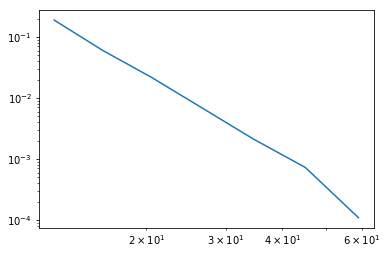

In [20]:
print(area_pwl.alpha, area_pwl.xmin)
area_pwl.plot_pdf()